# **Chapter 2: End-to-End ML project**

## 1. Look at the big picture.

#### **TODO** ...

## 2. Get the data.

In [157]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

In [158]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv("datasets/housing/housing.csv")

In [159]:
housing = load_housing_data()

In [160]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [161]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [162]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [163]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

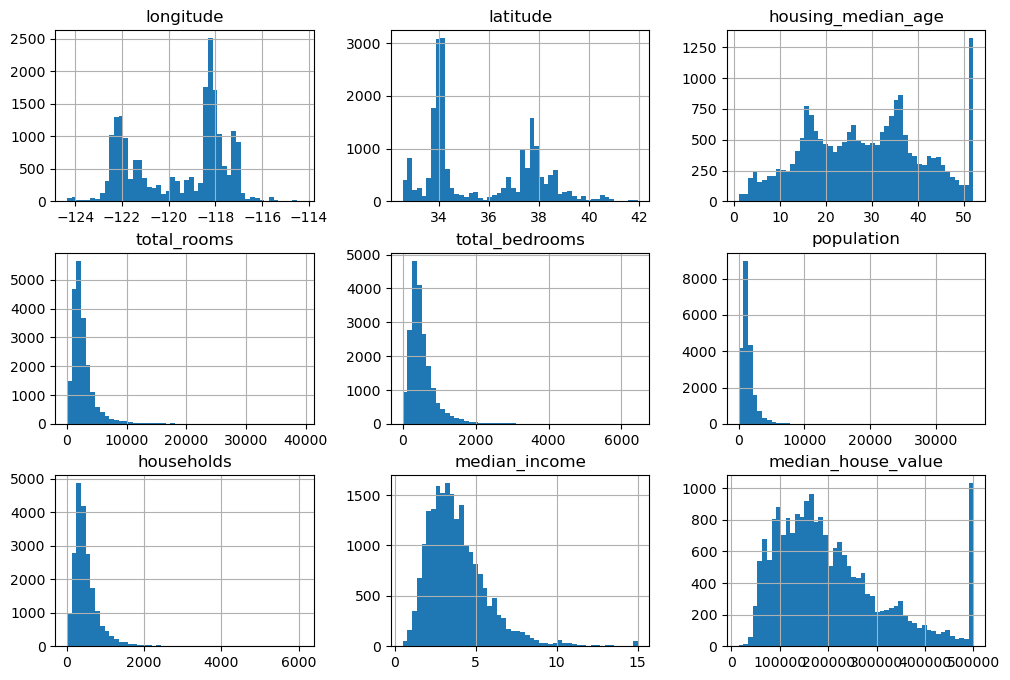

In [164]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [165]:
def shuffle_and_split_data(data, test_ratio):
    np.random.seed(99)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [166]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

In [167]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [168]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [169]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [170]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=99)

In [171]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0, 1.5, 3, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

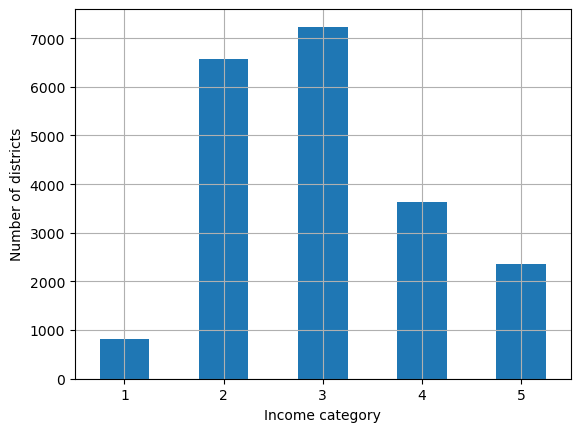

In [172]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [173]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=99)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [174]:
strat_train_set, strat_test_set = strat_splits[0]

In [175]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=99
)

In [176]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [177]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 3. Explore and visualize the data to gain insights.

In [178]:
housing = strat_train_set.copy()

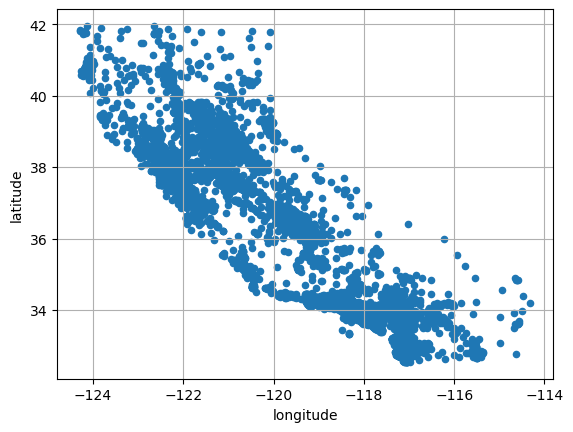

In [179]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

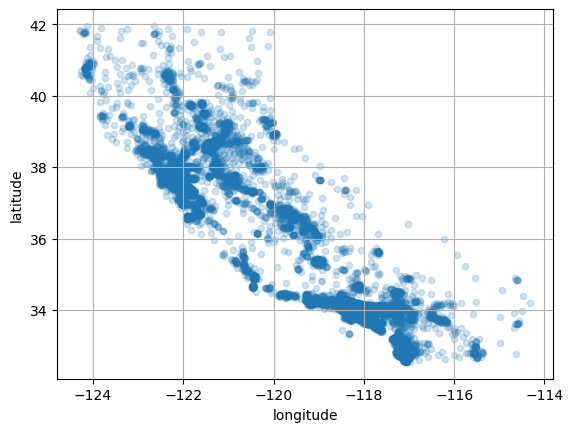

In [180]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

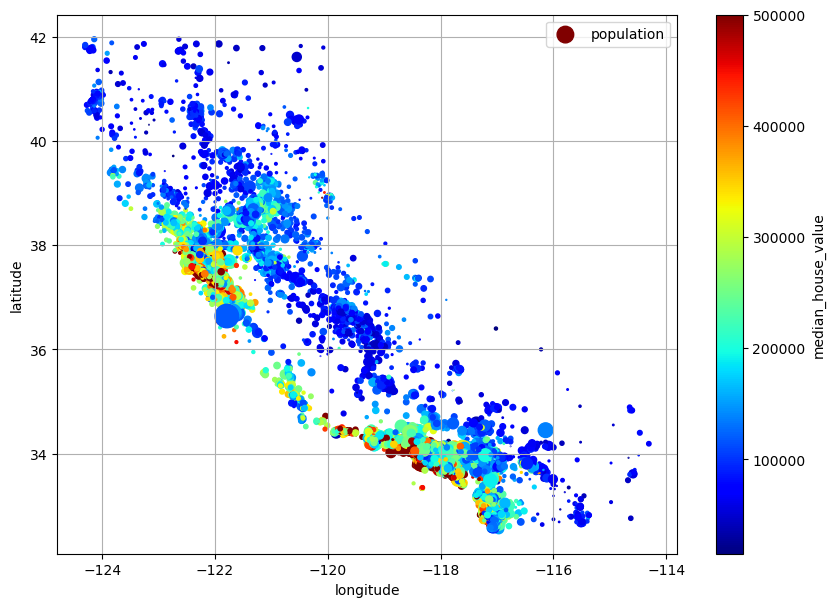

In [181]:
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    grid=True,
    s=housing["population"] / 100,
    label="population",
    c="median_house_value",
    cmap="jet",
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(10, 7)
)
plt.show()

In [182]:
corr_matrix = housing.corr(numeric_only=True)

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686748
total_rooms           0.138630
housing_median_age    0.102673
households            0.066335
total_bedrooms        0.050484
population           -0.024716
longitude            -0.047582
latitude             -0.143637
Name: median_house_value, dtype: float64

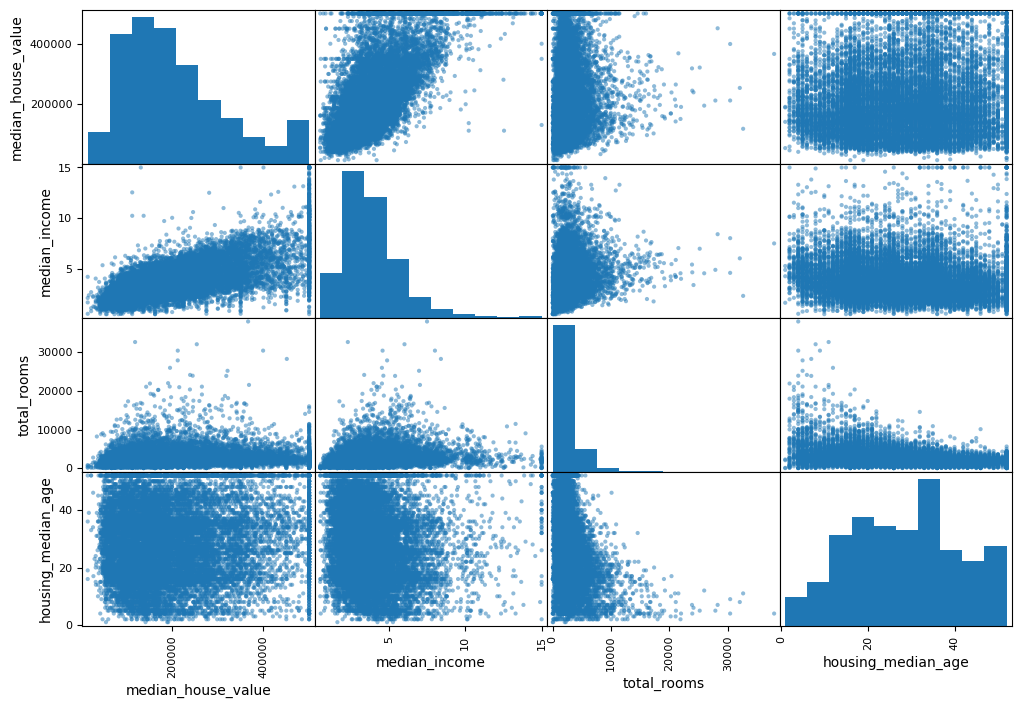

In [183]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

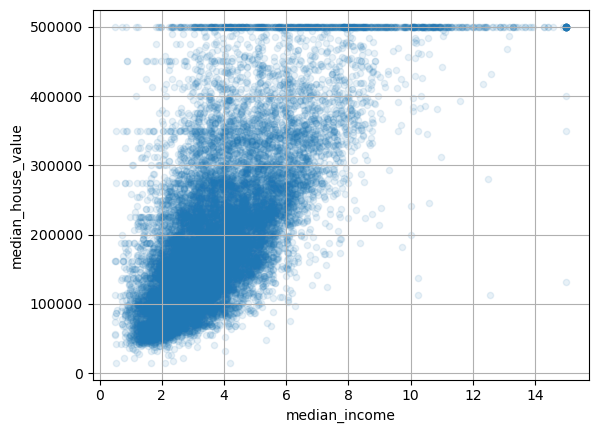

In [184]:
housing.plot(
    kind="scatter",
    x="median_income",
    y="median_house_value",
    alpha=0.1,
    grid=True
)
plt.show()

In [185]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [186]:
corr_matrix = housing.corr(numeric_only=True)

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686748
rooms_per_house       0.161719
total_rooms           0.138630
housing_median_age    0.102673
households            0.066335
total_bedrooms        0.050484
population           -0.024716
people_per_house     -0.027031
longitude            -0.047582
latitude             -0.143637
bedrooms_ratio       -0.256958
Name: median_house_value, dtype: float64

## 4. Prepare the data for machine learning algorithms.

In [187]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [188]:
housing.dropna(subset=["total_bedrooms"], inplace=True)

In [189]:
housing.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
3932,-122.45,37.77,52.0,2191.0,1100.0,585.0,3.0409,NEAR BAY
11364,-118.23,33.99,5.0,706.0,839.0,199.0,4.5208,<1H OCEAN
747,-118.21,33.92,37.0,1705.0,1839.0,410.0,2.5833,<1H OCEAN
951,-121.26,38.73,14.0,3323.0,1527.0,540.0,5.3451,INLAND
446,-121.91,37.28,29.0,5650.0,2098.0,813.0,6.4285,<1H OCEAN
...,...,...,...,...,...,...,...,...
161,-117.87,33.72,39.0,3167.0,2789.0,619.0,3.5902,<1H OCEAN
3020,-118.24,34.14,36.0,1813.0,1501.0,544.0,1.9125,<1H OCEAN
20131,-117.37,33.20,19.0,928.0,845.0,319.0,1.6318,NEAR OCEAN
5711,-118.42,34.23,33.0,2478.0,1567.0,446.0,5.6629,<1H OCEAN


In [190]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

/tmp/ipykernel_15767/2694038511.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median, inplace=True)


In [191]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [192]:
housing_num = housing.select_dtypes(include=[np.number])

In [193]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [194]:
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2115.    ,  433.    , 1163.    ,
        407.    ,    3.5417])

In [195]:
housing_num.median().values

array([-118.49  ,   34.25  ,   29.    , 2115.    ,  433.    , 1163.    ,
        407.    ,    3.5417])

In [196]:
X = imputer.transform(housing_num)

In [197]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
3932,-122.45,37.77,52.0,2191.0,627.0,1100.0,585.0,3.0409
11364,-118.23,33.99,5.0,706.0,203.0,839.0,199.0,4.5208
747,-118.21,33.92,37.0,1705.0,403.0,1839.0,410.0,2.5833
951,-121.26,38.73,14.0,3323.0,499.0,1527.0,540.0,5.3451
446,-121.91,37.28,29.0,5650.0,817.0,2098.0,813.0,6.4285


In [198]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
3932,NEAR BAY
11364,<1H OCEAN
747,<1H OCEAN
951,INLAND
446,<1H OCEAN
13642,INLAND
7098,INLAND
20501,INLAND


In [199]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [200]:
housing_cat_encoded

array([[3.],
       [0.],
       [0.],
       ...,
       [4.],
       [0.],
       [1.]], shape=(16329, 1))

In [201]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [202]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16329 stored elements and shape (16329, 5)>

In [203]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(16329, 5))

In [204]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [205]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test, dtype=int)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


In [206]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [222]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown, dtype=int)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,1,0
1,0,1


In [223]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [224]:
# https://github.com/scikit-learn-contrib/category_encoders

In [225]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [226]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [227]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


In [234]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [235]:
housing_num_min_max_scaled

array([[-0.62962963,  0.1106383 ,  1.        , ..., -0.92318734,
        -0.80792633, -0.64952208],
       [ 0.21521522, -0.69361702, -0.84313725, ..., -0.94146273,
        -0.93487913, -0.44540075],
       [ 0.21921922, -0.70851064,  0.41176471, ..., -0.87144208,
        -0.86548265, -0.71263845],
       ...,
       [ 0.38738739, -0.86170213, -0.29411765, ..., -0.94104261,
        -0.89541194, -0.84387802],
       [ 0.17717718, -0.64255319,  0.25490196, ..., -0.89048769,
        -0.85364249, -0.28787189],
       [-0.42942943,  0.2893617 ,  0.21568627, ..., -0.89454889,
        -0.79707285, -0.92517345]], shape=(16329, 8))

In [236]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

## 5. Select a model train it.

## 6. Present your solution.

## 7. Launch, monitor, and maintain your system.

#### **TODO:**
**Deploy your model to the cloud:**

- [Google Cloud AI](https://cloud.google.com/products/ai?hl=en) (Google Vertex AI, Google Cloud AI Platform, Google Cloud ML Engine)
- [Google Cloud Storage (GCS)](https://cloud.google.com/storage?hl=en)